In [1]:
import jax
from jax import jit
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device",jax.devices()[1])
import numpy as np
import jax.numpy as jnp

# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
)

from KernelTools import diagpart

from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k
from KernelTools import vectorize_kfunc

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import (
    CholeskyLM,SVD_LM,LMParams,plot_optimization_results
)

from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# coeffs of Burgers eqn
kappa = 0.01
alpha = 0.5
# IC
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

# solve Burgers eqn
u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999
                        )
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2876.09it/s]


In [3]:
# size of coll grid
num_grid_x, num_grid_t = 26, 26

# get interior and bdry pts of coll grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

# coll grid
tx_all = jnp.vstack([tx_bdy,tx_int])
# u vals at coll grid
u_all = u_true_function(tx_all)

# idx for IC
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
# idx for FC
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
# idx for IC + FC
tx_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
# obs grid
tx_obs = jnp.vstack([tx_bdy,tx_int[tx_sample_inds]])
# u vals at obs grid
u_obs = u_true_function(tx_obs)

In [4]:
# fine grid
num_fine_grid = 200
t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
# u vals at fine grid
u_true = u_true_function(tx_fine)

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

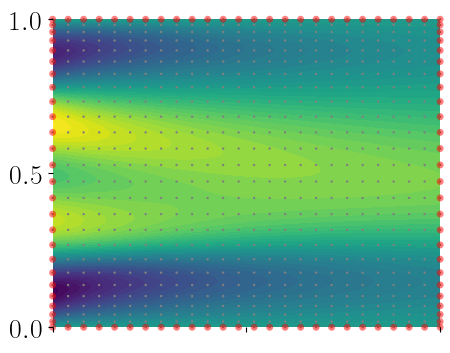

In [5]:
# u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 50, 
                vmin=-0.4532246910384856, 
                vmax=0.36374402)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 

In [6]:
# x fine grid
xfine = jnp.linspace(0,1,num_fine_grid)
# u vals at fine grid at IC
u_true_IC = u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid), xfine]).T)
# u vals at fine grid at FC
u_true_FC = u_true_function(jnp.vstack([1.0*jnp.ones(num_fine_grid), xfine]).T)

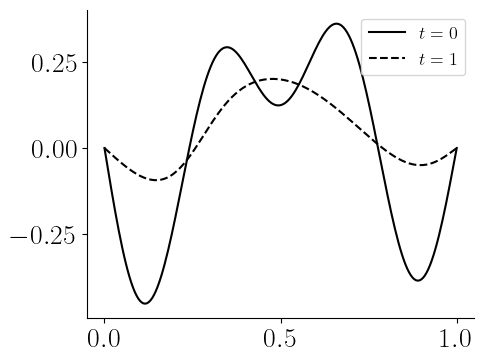

In [7]:
# u_true IC and FC plot
plt.figure(figsize=(5,4))
# Plot IC
plt.plot(xfine, u_true_IC,
         color = 'black',
         label = r'$t=0$')
# Plot FC
plt.plot(xfine,u_true_FC,
         linestyle = '--',
         color = 'black',
         label = r'$t=1$')

# fig settings
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="upper right",fontsize = 13)


In [8]:
# u basis ops
u_operators = (eval_k,dx_k,dt_k,dxx_k)
# L ops
feature_operators = (eval_k,dx_k,dxx_k)
# u kernel
k_u = get_gaussianRBF(jnp.sqrt(0.025/2))
# u RKHS 
u_model = CholInducedRKHS(tx_all,
                          u_operators,
                          k_u,
                          nugget_size = 1e-8
)
# u fitted params
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)
# L's at u
grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)
# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(2,
                                      grid_features_init,
                                      c=1.,
                                      scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return 10*k_P_u_part(x[2:],y[2:])
# P RKHS
P_model = OperatorModel(k_P)

# u and P object
EqnModel = OperatorPDEModel(P_model,
                            (u_model,),
                            (tx_obs,),
                            (u_obs,),
                            (tx_int,),
                            feature_operators,
                            rhs_operator=dt_k,
                            datafit_weight = 100
)

In [9]:
# options LM
optParams = LMParams(max_iter = 251,
                     init_alpha = 0.05,
                     min_alpha = 1e-16,
                     show_progress=True)
# initial params for LM
params_init = jnp.hstack([u_params_init,jnp.zeros(EqnModel.num_operator_params)])
# run LM
params,convergence_data = CholeskyLM(params_init.copy(),
                                     EqnModel,
                                     beta = 0.,
                                     optParams=optParams
)
# options SVD LM
svd_params = LMParams(max_iter=201,
                      init_alpha=convergence_data.alpha_vals[-1],
                      min_alpha=1e-16,
                      print_every=50,
                      step_adapt_multiplier=1.6)

# run SVD LM
p_adjusted,refine_convergence_data = SVD_LM(params,
                                            EqnModel,
                                            beta = 1e-16,
                                            optParams=svd_params)

  1%|          | 3/251 [00:29<32:08,  7.77s/it]  

Iteration 0, loss = 0.0922, gradnorm = 1.435e+03, alpha = 0.8543, improvement_ratio = 0.581
Iteration 1, loss = 0.04147, gradnorm = 2.096e+03, alpha = 0.8543, improvement_ratio = 0.7415
Iteration 2, loss = 0.01907, gradnorm = 308.5, alpha = 0.7119, improvement_ratio = 0.9331
Iteration 3, loss = 0.01214, gradnorm = 209.3, alpha = 0.5933, improvement_ratio = 0.9133


  4%|▎         | 9/251 [00:30<06:35,  1.63s/it]

Iteration 4, loss = 0.00854, gradnorm = 222.1, alpha = 0.4944, improvement_ratio = 0.8785
Iteration 5, loss = 0.005708, gradnorm = 281.7, alpha = 0.412, improvement_ratio = 0.9675


 22%|██▏       | 54/251 [00:31<00:08, 22.23it/s]

Iteration 50, loss = 4.194e-06, gradnorm = 4.712, alpha = 0.0001126, improvement_ratio = 0.9249


 42%|████▏     | 105/251 [00:34<00:05, 24.82it/s]

Iteration 100, loss = 3.61e-08, gradnorm = 0.3208, alpha = 2.139e-08, improvement_ratio = 0.504


 61%|██████    | 153/251 [00:36<00:04, 23.44it/s]

Iteration 150, loss = 1.253e-08, gradnorm = 0.03482, alpha = 1.522e-08, improvement_ratio = 0.6709


 81%|████████▏ | 204/251 [00:38<00:02, 23.28it/s]

Iteration 200, loss = 9.372e-09, gradnorm = 0.04866, alpha = 1.502e-08, improvement_ratio = 0.9983


100%|██████████| 251/251 [00:40<00:00,  6.23it/s]


Iteration 250, loss = 7.872e-09, gradnorm = 0.01524, alpha = 1.482e-08, improvement_ratio = 0.9987


  1%|          | 2/201 [00:25<34:55, 10.53s/it]  

Iteration 0, loss = 7.846e-09, gradnorm = 0.001706, alpha = 9.261e-09, improvement_ratio = 0.9997
Iteration 1, loss = 7.804e-09, gradnorm = 0.0007528, alpha = 5.788e-09, improvement_ratio = 0.9995


  2%|▏         | 4/201 [00:25<11:37,  3.54s/it]

Iteration 2, loss = 7.74e-09, gradnorm = 0.001884, alpha = 3.617e-09, improvement_ratio = 0.9988
Iteration 3, loss = 7.64e-09, gradnorm = 0.004679, alpha = 2.261e-09, improvement_ratio = 0.9967


  3%|▎         | 6/201 [00:25<05:03,  1.56s/it]

Iteration 4, loss = 7.489e-09, gradnorm = 0.01135, alpha = 1.413e-09, improvement_ratio = 0.9898
Iteration 5, loss = 7.272e-09, gradnorm = 0.02692, alpha = 8.832e-10, improvement_ratio = 0.9676


 26%|██▌       | 52/201 [00:30<00:16,  9.21it/s]

Iteration 50, loss = 2.229e-10, gradnorm = 0.09699, alpha = 2.167e-13, improvement_ratio = 0.9769


 51%|█████     | 102/201 [00:36<00:10,  9.21it/s]

Iteration 100, loss = 8.86e-11, gradnorm = 0.005374, alpha = 1.705e-13, improvement_ratio = 0.679


 76%|███████▌  | 152/201 [00:41<00:05,  9.21it/s]

Iteration 150, loss = 6.904e-11, gradnorm = 0.006057, alpha = 1.554e-13, improvement_ratio = 0.9856


100%|██████████| 201/201 [00:47<00:00,  4.26it/s]


Iteration 200, loss = 5.874e-11, gradnorm = 0.008551, alpha = 6.411e-14, improvement_ratio = 0.9219


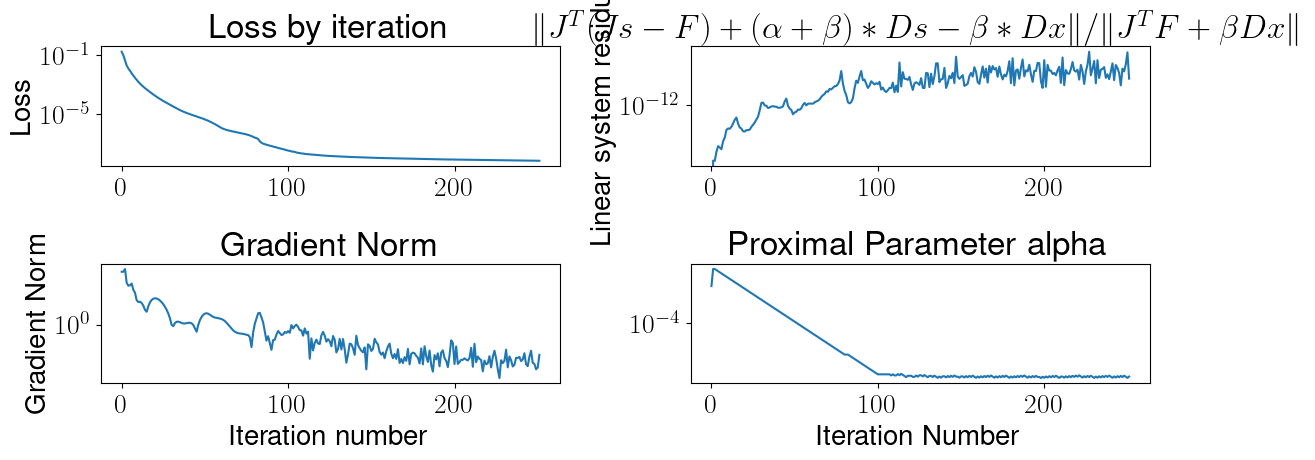

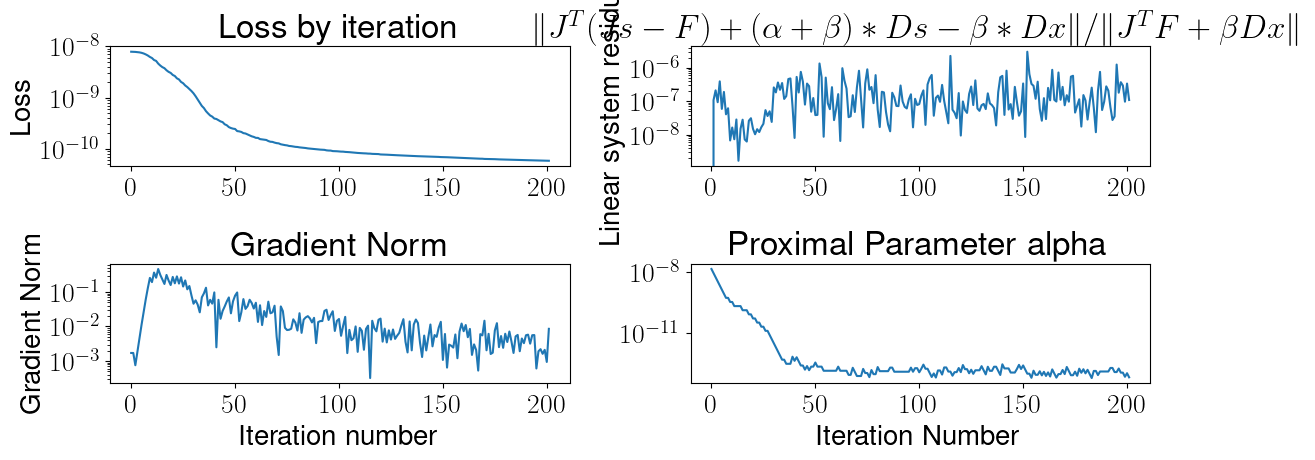

In [10]:
# converence history plot
plot_optimization_results(convergence_data)
plot_optimization_results(refine_convergence_data)

In [11]:
# loss history
loss_vals_LM = convergence_data.loss_vals
loss_vals_SVDLM = refine_convergence_data.loss_vals

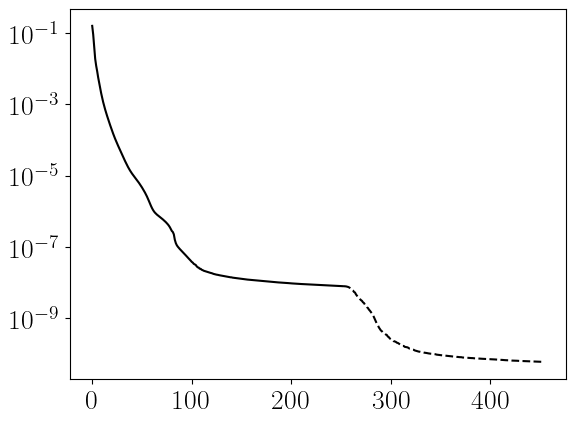

In [12]:
# Convergence history
plt.plot(range(len(loss_vals_LM)),
         loss_vals_LM,
         color = 'black',
         ls = 'solid')
plt.plot(jnp.arange(len(loss_vals_LM),
                    len(loss_vals_LM) + len(loss_vals_SVDLM)),
        loss_vals_SVDLM,
        color = 'black',
        ls = 'dashed'
)
plt.yscale('log')

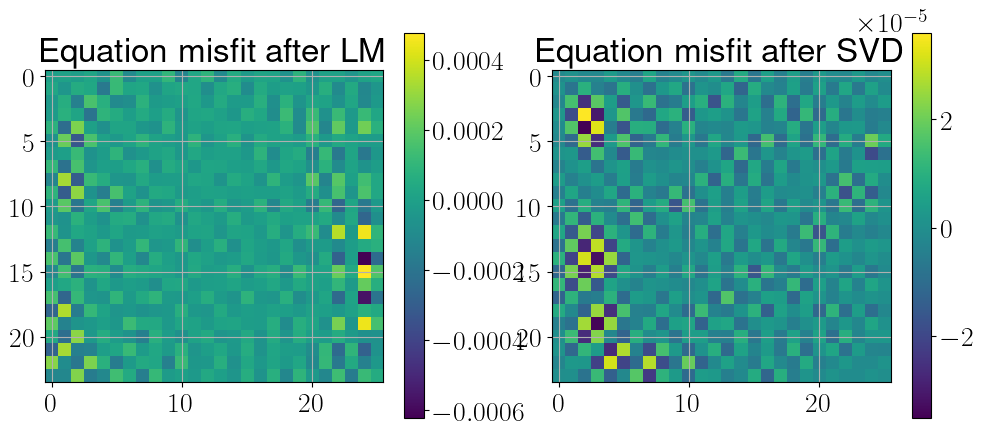

Pre Refinement  1.0712492983130565e-08
Post Refinement  9.01177578779333e-11


In [13]:
# equation residuals plot
equation_residuals = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(params),EqnModel.get_P_params(params)
    )

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()
plt.subplot(1,2,2)

equation_residuals_refined = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(p_adjusted),EqnModel.get_P_params(p_adjusted)
    )
plt.title("Equation misfit after SVD")
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

In [14]:
# get u params
u_sol = p_adjusted[:u_model.num_params]
# get P params
P_sol = p_adjusted[u_model.num_params:]

# u_pred vals at fine grid
u_pred = u_model.point_evaluate(tx_fine,u_sol)

# u error at fine grid
print(get_nrmse(u_true,u_pred))

0.0035750549825740606


[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

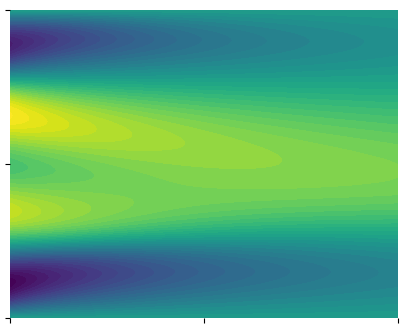

In [15]:
# u_pred plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_pred,
                levels= 50, 
                vmin=-0.4532246910384856, 
                vmax=0.36374402)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

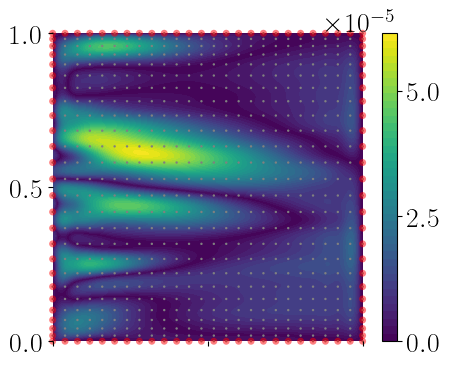

In [16]:
# u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(u_true - u_pred)/jnp.linalg.norm(u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_xticklabels([]) 

### Testing on new IC

In [17]:
# new IC
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0
# solve Burgers with new IC
new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:03<00:00, 2952.82it/s]


In [18]:
# new_u vals at fine grid at IC
new_u_true_IC = new_u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid), xfine]).T)
# u vals at fine grid at FC
new_u_true_FC = new_u_true_function(jnp.vstack([1.0*jnp.ones(num_fine_grid), xfine]).T)

[Text(0, -0.5, ''), Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

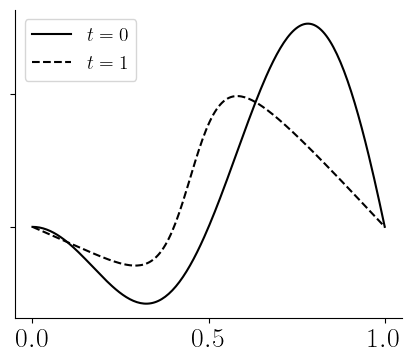

In [19]:
# u_true IC and FC plot
plt.figure(figsize=(5,4))
# Plot IC
plt.plot(xfine, new_u_true_IC,
         color = 'black',
         label = r'$t=0$')
# Plot FC
plt.plot(xfine, new_u_true_FC,
         linestyle = '--',
         color = 'black',
         label = r'$t=1$')

# fig settings
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize = 14)
plt.gca().set_yticklabels([]) 

In [20]:
# solve burgers with new IC using GP method
def get_u_pde_adj(u0_new):
    
    model_grid_features = EqnModel.single_eqn_features(u_model,u_sol,tx_int)
    # Phat of 1 step method
    @jit
    def get_pred_ut(input_features):
        return P_model.kernel_function(input_features,model_grid_features)@P_sol

    # Observations at ICs and BCs
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])
    new_obs = u0_new(tx_init_bdy) 

    # Set the PDE model
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jax.jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)

    ## OPTIMIZE

    optParams = LMParams(
        max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

    new_u_init = 0*u_sol

    u_pde_params,convergence_data = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        optParams=optParams
    )
    svd_params = LMParams(
        max_iter=201,
        init_alpha=convergence_data.alpha_vals[-1],
        min_alpha=1e-16,print_every=50,
        step_adapt_multiplier=1.6)


    u_pde_params_adj,_ = SVD_LM(u_pde_params,PdeModel,beta = 1e-16,optParams=svd_params)

    return u_pde_params_adj 

In [21]:
# solve Burgers with new IC 
new_u_params = get_u_pde_adj(new_u_true_function)

  2%|▏         | 5/251 [00:27<16:40,  4.07s/it]  

Iteration 0, loss = 0.05608, gradnorm = 145.2, alpha = 0.04167, improvement_ratio = 0.9991
Iteration 1, loss = 0.003896, gradnorm = 0.2665, alpha = 0.03472, improvement_ratio = 0.9306
Iteration 2, loss = 1.06e-05, gradnorm = 0.04026, alpha = 0.02894, improvement_ratio = 0.9996
Iteration 3, loss = 4.354e-06, gradnorm = 0.0009716, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 3.736e-06, gradnorm = 3.564e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 3.28e-06, gradnorm = 2.517e-06, alpha = 0.01674, improvement_ratio = 1.0


 23%|██▎       | 57/251 [00:28<00:08, 22.62it/s]

Iteration 50, loss = 6e-08, gradnorm = 1.494e-08, alpha = 4.579e-06, improvement_ratio = 1.0


 42%|████▏     | 105/251 [00:30<00:04, 30.69it/s]

Iteration 100, loss = 4.17e-09, gradnorm = 1.599e-07, alpha = 3.821e-09, improvement_ratio = 1.002


 63%|██████▎   | 157/251 [00:32<00:03, 30.41it/s]

Iteration 150, loss = 2.29e-09, gradnorm = 5.799e-07, alpha = 4.711e-09, improvement_ratio = 0.9978


 81%|████████▏ | 204/251 [00:33<00:01, 30.87it/s]

Iteration 200, loss = 1.63e-09, gradnorm = 4.351e-07, alpha = 3.873e-09, improvement_ratio = 1.0


100%|██████████| 251/251 [00:35<00:00,  7.14it/s]


Iteration 250, loss = 1.342e-09, gradnorm = 5.98e-07, alpha = 4.777e-09, improvement_ratio = 1.023


  1%|          | 2/201 [00:25<34:57, 10.54s/it]  

Iteration 0, loss = 1.481e-09, gradnorm = 5.716e-07, alpha = 6.717e-09, improvement_ratio = 5.275
Iteration 1, loss = 1.481e-09, gradnorm = 5.81e-07, alpha = 7.173e-08, improvement_ratio = 22.08


  1%|▏         | 3/201 [00:25<28:26,  8.62s/it]

Iteration 2, loss = 1.481e-09, gradnorm = 5.225e-07, alpha = 8.725e-06, improvement_ratio = 34.92
Line Search Failed!
Final Iteration Results
Iteration 3, loss = 1.482e-09, gradnorm = 5.225e-07, alpha = 0.04642, improvement_ratio = -212.3


In [22]:
# new_u vals at fine grid
new_u_true = new_u_true_function(tx_fine)

# new_u_pred vals at fine grid
new_u_pred = u_model.point_evaluate(tx_fine,new_u_params)

print(get_nrmse(new_u_true,new_u_pred))

0.019188669822249885


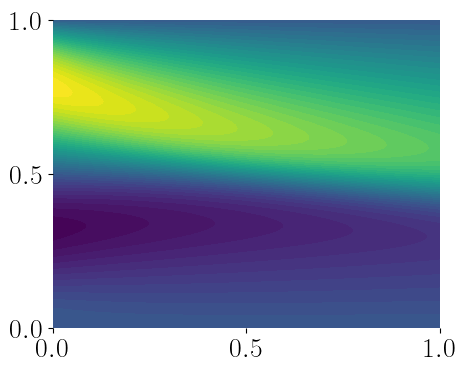

In [23]:
# new_u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, new_u_true,
                levels= 50)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

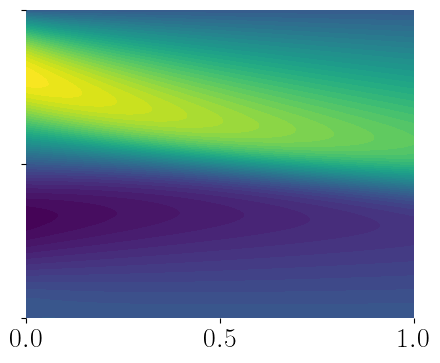

In [24]:
# new_u_pred plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, new_u_pred,
                levels= 50)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_yticklabels([]) 

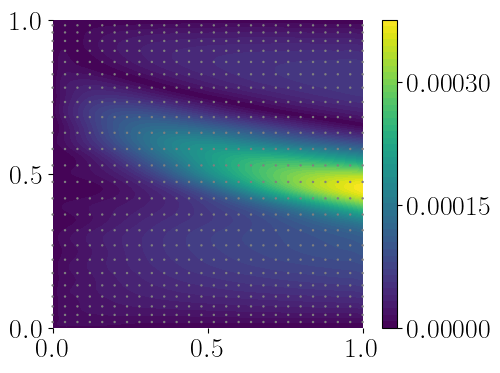

In [25]:
# new_u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(new_u_true - new_u_pred)/jnp.linalg.norm(new_u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_int.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

In [26]:
# store data
data = {'tx_obs': tx_obs,
        'tx_all': tx_all,
        'tx_int': tx_int,
        'tx_bdy': tx_bdy,
        'tx_fine': tx_fine,
        'xfine': xfine,
        'u_true': u_true,
        'u_pred': u_pred,
        'u_true_IC': u_true_IC,
        'u_true_FC': u_true_FC,
        'new_u_true': new_u_true,
        'new_u_pred': new_u_pred,
        'new_u_true_IC': new_u_true_IC,
        'new_u_true_FC': new_u_true_FC,
        'loss_vals_LM': loss_vals_LM,
        'loss_vals_SVDLM': loss_vals_SVDLM
}

In [27]:
# save data
np.save('data.npy', np.array(data, dtype=object), allow_pickle=True)

: 